In [2]:
pip install pyogrio


Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from pyproj import CRS
from haversine import haversine, Unit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
%matplotlib inline

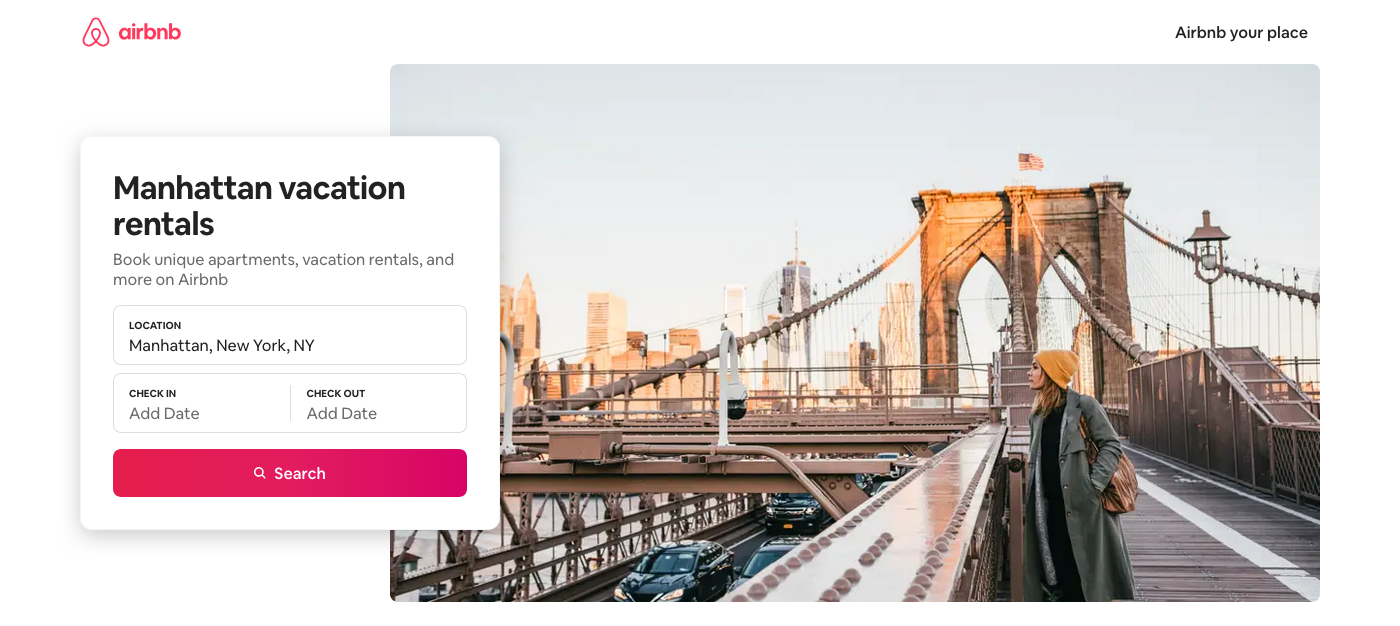

# Introduction 

This project provides a comprehensive analysis of a dataset containing listings for Airbnb properties in New York City. By examining various factors such as location, property type, and price, the goal is to uncover patterns and trends that influence the pricing of these listings. Through data cleaning, exploratory data analysis (EDA), and statistical modeling, this project aims to provide actionable insights into the NYC short-term rental market. Ultimately, my goal is to enhance understanding of the market dynamics influencing Airbnb prices while offering valuable insights for potential hosts, investors, and anyone interested in Airbnb pricing.

In [5]:
# Read csv file
nyc_airbnb = pd.read_csv('NYC-Airbnb-2023.csv')

/var/folders/s6/yfykrb550rd2xphpx7ww82xm0000gn/T/ipykernel_2675/3410307204.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_airbnb = pd.read_csv('NYC-Airbnb-2023.csv')


In [6]:
nyc_airbnb.head(n=10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1,NaN
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0,NaN
2,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0,NaN
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52,NaN
4,5136,"Large Sunny Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1,NaN
5,29628,"Comfortable, Sunny Room",127608,Chris,Brooklyn,Clinton Hill,40.68292,-73.96381,Private room,93,3,350,2023-02-27,2.25,1,145,48,NaN
6,5586,Rooftop Deck/City Views. Great Apt,8526,Susan,Manhattan,Upper East Side,40.76076,-73.96156,Entire home/apt,295,4,45,2022-10-03,0.27,1,1,4,NaN
7,5803,"Lovely, Cozy, Room 1, BEST AREA; Legal Rental",9744,Laurie,Brooklyn,South Slope,40.66801,-73.98784,Private room,124,3,223,2023-02-13,1.32,3,164,17,NaN
8,31130,Most Central Location!,117287,Lara Nicole,Manhattan,Hell's Kitchen,40.76720,-73.98464,Private room,200,1,68,2021-10-01,0.44,4,310,0,NaN
9,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81,30,189,2023-02-04,1.13,1,207,5,NaN


In [7]:
nyc_airbnb.shape # View dimensions (rows, cols)

(42931, 18)

# Data Cleaning

Before starting my analysis, I needed to ensure the data was clean and ready for exploration. This involved checking for duplicate rows, null values, and any other inconsistencies in the data. Once cleaned, I was able to begin exploring the data using various visualization techniques. 

In [8]:
# Check for duplicate rows
nyc_airbnb.duplicated().sum()

0

In [9]:
nyc_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42931 entries, 0 to 42930
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42931 non-null  int64  
 1   name                            42919 non-null  object 
 2   host_id                         42931 non-null  int64  
 3   host_name                       42926 non-null  object 
 4   neighbourhood_group             42931 non-null  object 
 5   neighbourhood                   42931 non-null  object 
 6   latitude                        42931 non-null  float64
 7   longitude                       42931 non-null  float64
 8   room_type                       42931 non-null  object 
 9   price                           42931 non-null  int64  
 10  minimum_nights                  42931 non-null  int64  
 11  number_of_reviews               42931 non-null  int64  
 12  last_review                     

In [42]:
nyc_airbnb.describe()
# After running the describe method , I notice some anomalies in the data. The min price value is 0 which doesn't make sense. In addition, I notice an extreme outlier based on the max value. I will deal with these in the data cleaning phase. 

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,4.290400e+04,4.290400e+04,42904.000000,42904.000000,42904.000000,42904.000000,42904.000000,32608.000000,42904.000000,42904.000000,42904.000000
mean,2.224171e+17,1.514943e+08,40.728262,-73.943641,200.433223,18.116539,25.828641,1.168162,24.069015,140.350480,7.731820
std,3.344800e+17,1.621208e+08,0.057653,0.056634,895.350407,27.468313,56.526688,1.788371,80.891405,142.002547,18.285965
min,2.595000e+03,1.678000e+03,40.500314,-74.251907,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,1.938814e+07,1.606267e+07,40.687470,-73.981725,75.000000,2.000000,1.000000,0.140000,1.000000,0.000000,0.000000
50%,4.337518e+07,7.432172e+07,40.724020,-73.952590,125.000000,7.000000,5.000000,0.520000,1.000000,89.000000,0.000000
75%,6.307064e+17,2.676851e+08,40.762291,-73.924010,200.000000,30.000000,24.000000,1.670000,4.000000,289.000000,7.000000
max,8.404660e+17,5.038729e+08,40.911380,-73.710870,99000.000000,1250.000000,1842.000000,86.610000,526.000000,365.000000,1093.000000


In [11]:
nyc_airbnb_sorted = nyc_airbnb.sort_values(by="price", ascending=False)
nyc_airbnb_sorted.head(n=20)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
34299,683438366892259448,46th Floor Private Rooftop,472600679,Alisa,Brooklyn,Williamsburg,40.715780,-73.966570,Entire home/apt,99000,1,1,2022-08-18,0.15,1,365,1,NaN
32440,638990296543110131,Groovy bedroom in BK next to METRO & Industry ...,51913277,Andrada,Brooklyn,Sunset Park,40.655350,-74.002980,Private room,85170,1,38,2022-12-31,4.52,6,57,38,NaN
34929,695003935229257623,"Artsy, Trendy, Warm, Home - Extra!",18586628,Udeaku,Manhattan,East Harlem,40.811980,-73.935970,Private room,85100,1,15,2022-12-31,2.34,2,21,15,NaN
9418,16289102,"Comfy private room, great location to Manhattan",92493393,Lois,Staten Island,West Brighton,40.633040,-74.112750,Private room,65115,2,55,2022-07-29,0.72,3,2,5,NaN
9809,17416959,A Group Stay10 ppl w.3-4 BRs max guests 32,1261480,Doungrat (Diane),Manhattan,Harlem,40.807170,-73.950650,Private room,20500,3,0,NaN,NaN,8,362,0,NaN
31388,603665411466936794,New York Estate,34906299,Lilian,Manhattan,Upper East Side,40.765260,-73.971710,Entire home/apt,19750,7,0,NaN,NaN,2,365,0,NaN
33266,658503812592195974,Big 2 bedroom two bathroom in a doorman building.,363776653,Marlon McWilliams,Manhattan,East Harlem,40.786225,-73.942838,Entire home/apt,15000,21,0,NaN,NaN,1,0,0,NaN
12643,22436899,1-BR Lincoln Center,72390391,Jelena,Manhattan,Upper West Side,40.771840,-73.988350,Entire home/apt,10000,30,0,NaN,NaN,1,0,0,NaN
27614,52862058,Lux Studio on Wall Street. Heart of Fidi!,57586379,Chris,Manhattan,Financial District,40.706410,-74.009200,Entire home/apt,10000,30,1,2021-12-13,0.07,1,83,0,NaN
18941,38993679,"The Gregory Hotel, Tailored King with Sofa Bed",298338860,The Gregory Hotel,Manhattan,Midtown,40.750880,-73.986440,Private room,10000,30,1,2020-03-01,0.03,3,365,0,NaN


In [12]:
# Remove rows where price is equal to zero.
nyc_airbnb = nyc_airbnb.drop(nyc_airbnb[nyc_airbnb['price'] == 0].index)
nyc_airbnb.shape

(42904, 18)

In [13]:
# Since the license column is almost entirely null values and does not provide useful information to me, I am going to drop it from my DataFrame
nyc_airbnb = nyc_airbnb.drop(columns=['license'])
nyc_airbnb.head() 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0
2,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52
4,5136,"Large Sunny Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1


In [14]:
nyc_map = gpd.read_file('nybb.shp')
print(nyc_map)

   BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  325910.306061  1.623619e+09   
1         1      Manhattan  360037.634094  6.366460e+08   
2         2          Bronx  463180.578868  1.187175e+09   
3         3       Brooklyn  728143.833073  1.934143e+09   
4         4         Queens  887896.284851  3.041417e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((981219.056 188655.316, 980940....  
2  MULTIPOLYGON (((1012821.806 229228.265, 101278...  
3  MULTIPOLYGON (((1022227.320 152028.146, 102207...  
4  MULTIPOLYGON (((1032452.015 154469.237, 103245...  


In [15]:
print(nyc_map.columns)

Index(['BoroCode', 'BoroName', 'Shape_Leng', 'Shape_Area', 'geometry'], dtype='object')


# Exploratory Data Analysis

In this section, I sought to gain initial insights into the factors influencing Airbnb pricing in New York City. To begin, I used GeoPandas to create a map that provides a high-level view of where higher-priced listings are concentrated and whether certain neighborhoods or areas stand out.

Next, I examined the overall distribution of prices using a histogram. This helped me to understand the range of prices and identify any potential skewness or outliers in the dataset. I then explored pricing trends by borough, using a bar chart to display the median price across New York City's five boroughs. This revealed the variations in pricing between different regions, highlighting Manhattan as a key driver of higher prices.

I was then curious to know which Manhattan neighborhoods were the most desireable. This lead me to create another bar chart analyzing median prices across individual neighborhoods. This allowed me to see how local factors influence pricing within Manhattan, providing a more granular understanding of pricing patterns.

Because Manhattan is such a strong driver of higher prices, I wanted to investigate the extent to which proximity to central Manhattan affected listing price, so I created scatter plots to visualize the relationship and potentially create a predicative model that could be used to forecast prices based on location. By plotting listings based on their distance from Manhattan, I was able to explore whether proximity to the heart of Manhattan correlated with higher prices. These scatter plots also helped identify any outliers or interesting patterns in the data, suggesting how distance might influence pricing decisions for both hosts and guests.

Through these visualizations, I was able to uncover initial patterns and relationships in the dataset that could inform further analysis and help identify key factors that impact Airbnb pricing in New York City.

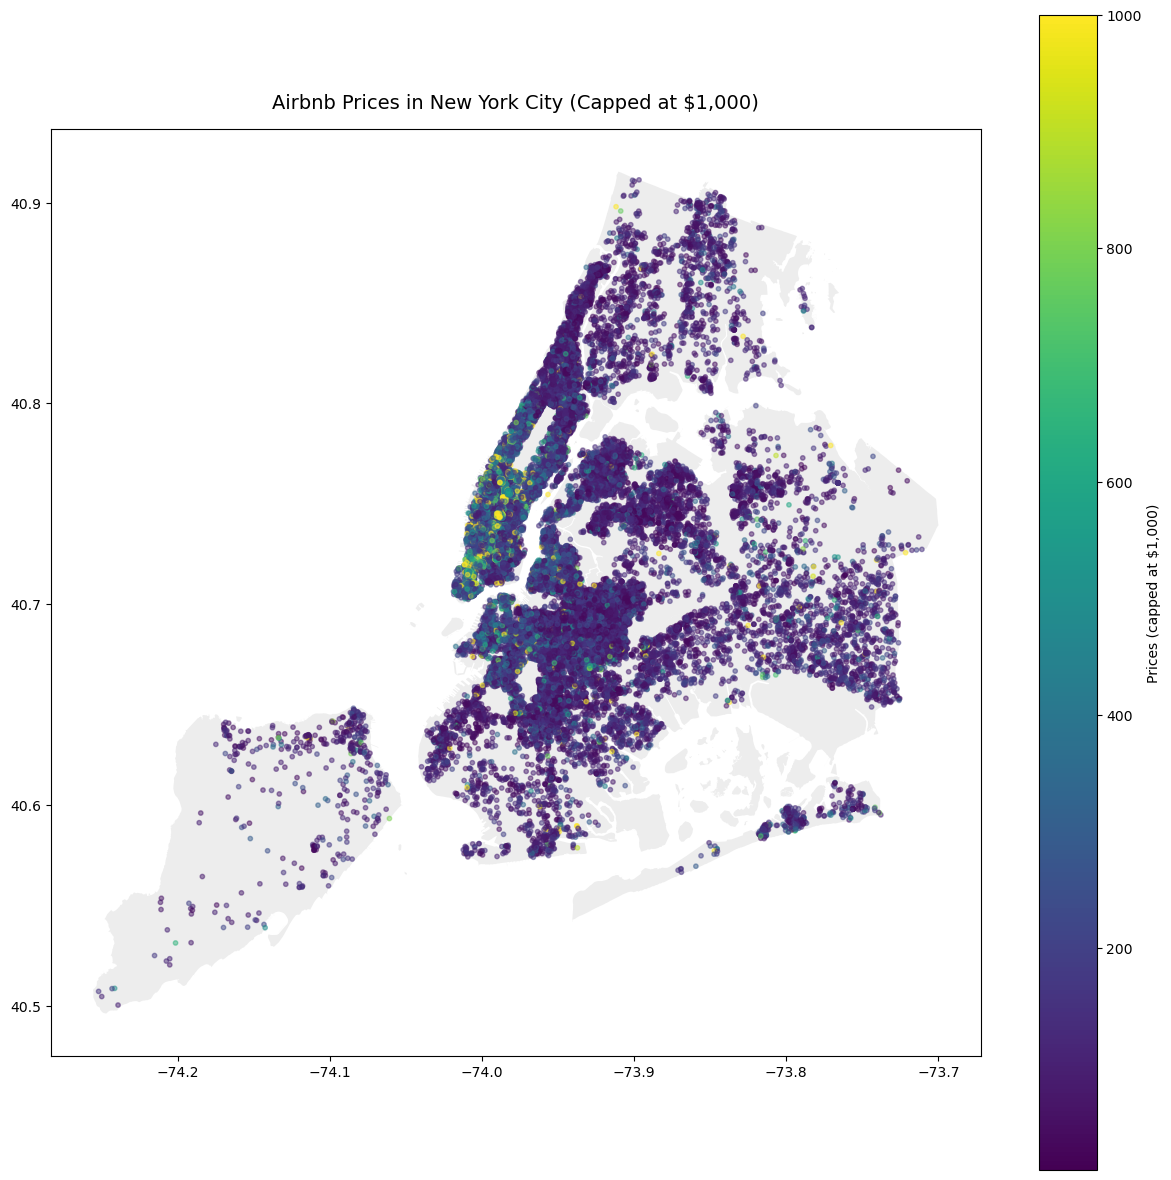

Text(0.5, 0.02, 'There are 626 listings above $1,000. The percentage of capped listings is 1.46%')

<Figure size 640x480 with 0 Axes>

In [16]:
# Since I am not super familiar with GeoPandas, I used this article, along with the Geopandas documentation, to help me write this section of code: https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391
geometry = [Point(xy) for xy in zip(nyc_airbnb["longitude"], nyc_airbnb["latitude"])]

# Create GeoPandas Data Frame
geo_df = gpd.GeoDataFrame(nyc_airbnb, geometry=geometry, crs="EPSG:4326")

# Create price column that is capped at $1000. I did this because some extreme outliers where skewing my legend
geo_df['price_capped'] = geo_df['price'].clip(upper=1000)

# Calculate percentage of listings capped at $1000
total_listings = len(geo_df)
capped_listings = len(geo_df[geo_df['price'] > 1000])
capped_percentage = (capped_listings / total_listings) * 100
capped_percentage_rounded = round(capped_percentage, 2)

# Convert coordinate reference system of NYC map to CRS of data points 
nyc_map = nyc_map.to_crs(geo_df.crs)
    
fig, ax = plt.subplots(figsize=(15, 15))

# Plot NYC map
nyc_map.plot(ax=ax, alpha=0.4, color="lightgrey")

# Plot Airbnb locations on NYC map
geo_df.plot(column="price_capped", ax=ax, alpha=0.5, legend=True, markersize=10, legend_kwds={'label': f'Prices (capped at $1,000)', 'orientation': 'vertical'}, cmap='viridis')
plt.title("Airbnb Prices in New York City (Capped at $1,000)", fontsize = 14, pad=15)
plt.show()

# Add text to figure indicating number and percentage of listings capped at $1,000
plt.figtext(0.5, 0.02, f"There are {capped_listings} listings above $1,000. The percentage of capped listings is {capped_percentage_rounded}%", ha='center', fontsize=12)

As expected the highest priced Airbnb listings are those located in and around downtown Manhattan. The majority of listings outside the immediate proximity of downtown Manhattan fall under $200 per night. 

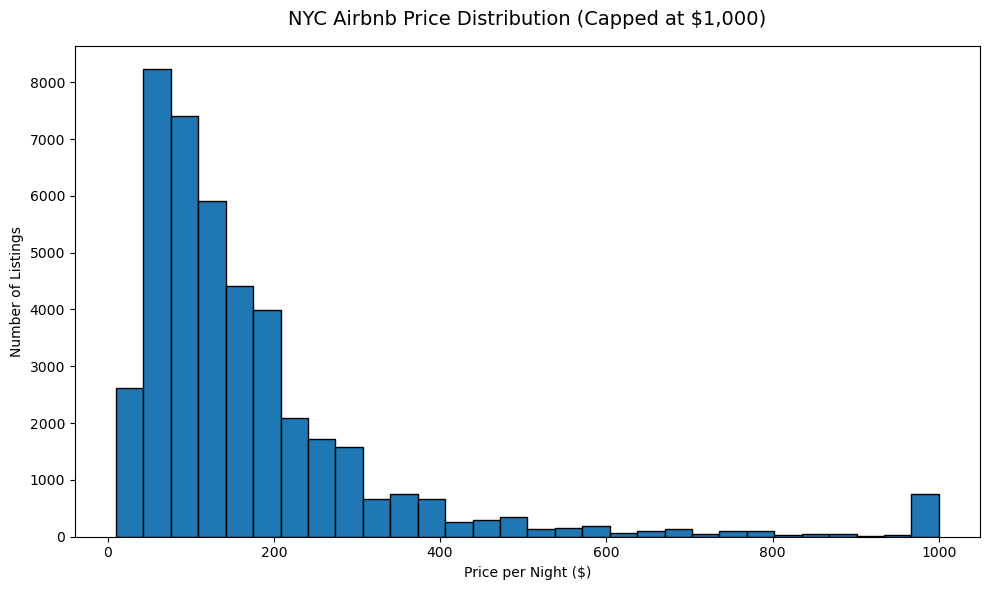

In [17]:
# Create histogram of price distribution with prices capped at $1000 to deal with extreme outliers (some of which may be data-entry errors)
fig, ax = plt.subplots(figsize = (10,6))
clipped_prices = np.clip(nyc_airbnb['price'].values, a_min=None, a_max=1000)
plt.hist(clipped_prices, bins=30, edgecolor='black') 
plt.title('NYC Airbnb Price Distribution (Capped at $1,000)', fontsize = 14, pad=15)
plt.xlabel('Price per Night ($)', fontsize=10)
plt.ylabel('Number of Listings', fontsize=10)
plt.tight_layout()
plt.show()

The histogram is right-skewed, with the bulk of the listing prices falling under $200 per night. There are a few outliers in the tail. 

In [18]:
# Median price by borough
neighborhood_median_df = nyc_airbnb.groupby('neighbourhood_group')['price'].median()
neighborhood_median_df = neighborhood_median_df.reset_index()
print(neighborhood_median_df)

  neighbourhood_group  price
0               Bronx   87.0
1            Brooklyn  110.0
2           Manhattan  165.0
3              Queens   90.0
4       Staten Island   99.0


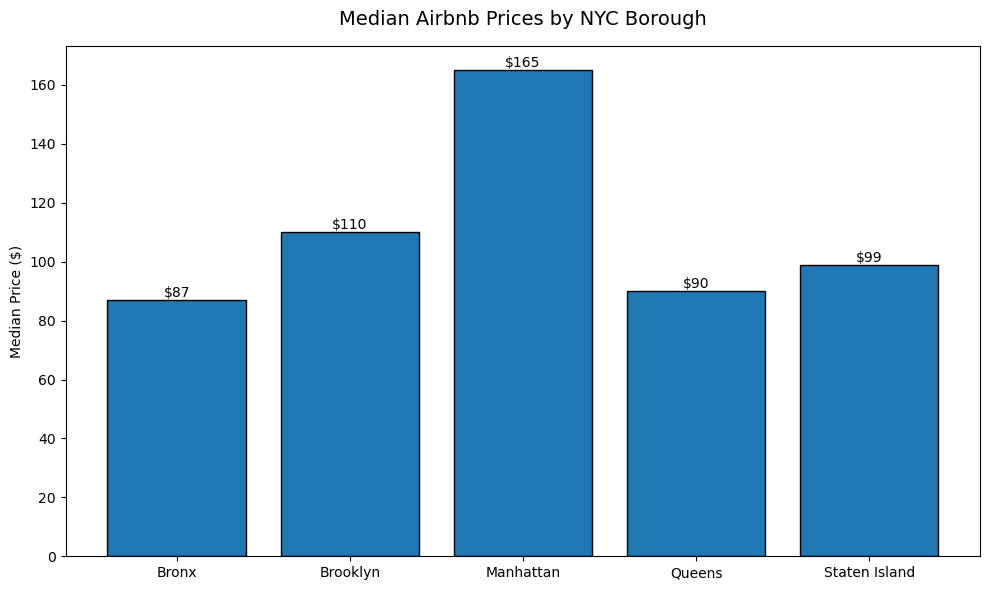

In [19]:
# Visualize the data 
plt.figure(figsize=(10, 6))
bars = plt.bar(neighborhood_median_df['neighbourhood_group'], neighborhood_median_df['price'], edgecolor='black')
plt.title('Median Airbnb Prices by NYC Borough', fontsize = 14, pad=15)
plt.bar_label(bars, fmt='$%.0f')
plt.ylabel('Median Price ($)')


plt.tight_layout()
plt.show()

Not surprisingly, Manhattan has the highest median Airbnb price of the five boroughs. Brooklyn, which is separted from Manhattan only by the East River and is easily acessible via the Brooklyn Bridge, has the second-highest median Airbnb price. This further supports my idea that proximity to Manhattan and its tourist attractions is a strong driver of higher Airbnb prices. 

In [20]:
# Median price by Manhattan neighborhood
manhattan_airbnb = nyc_airbnb.drop(nyc_airbnb[nyc_airbnb['neighbourhood_group'] != 'Manhattan'].index)
manhattan_airbnb.head(n=5)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1
2,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52
6,5586,Rooftop Deck/City Views. Great Apt,8526,Susan,Manhattan,Upper East Side,40.76076,-73.96156,Entire home/apt,295,4,45,2022-10-03,0.27,1,1,4
8,31130,Most Central Location!,117287,Lara Nicole,Manhattan,Hell's Kitchen,40.76720,-73.98464,Private room,200,1,68,2021-10-01,0.44,4,310,0


In [21]:
manhattan_median_df = manhattan_airbnb.groupby('neighbourhood')['price'].median().reset_index()
manhattan_median_df

,neighbourhood,price
0,Battery Park City,200.0
1,Chelsea,200.0
2,Chinatown,140.0
3,Civic Center,174.0
4,East Harlem,110.0
5,East Village,157.0
6,Financial District,239.0
7,Flatiron District,189.0
8,Gramercy,155.0
9,Greenwich Village,200.0


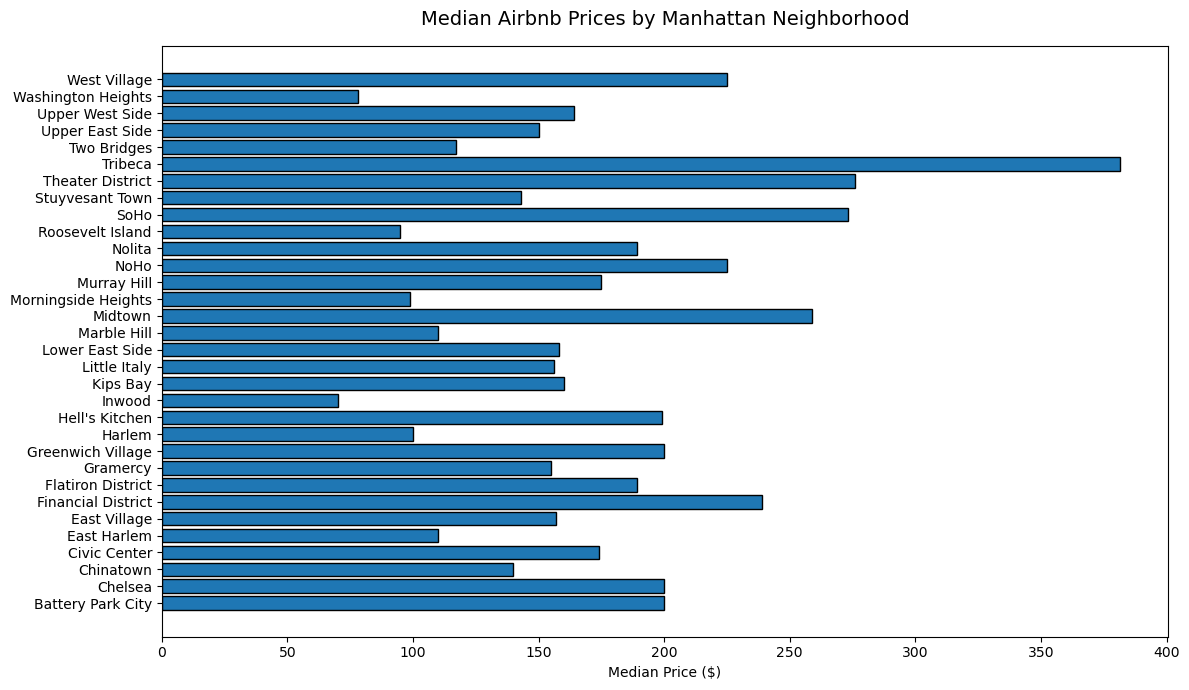

In [48]:
plt.figure(figsize=(12, 7))
plt.barh(manhattan_median_df['neighbourhood'], manhattan_median_df['price'], edgecolor='black')
plt.title('Median Airbnb Prices by Manhattan Neighborhood', fontsize= 14, pad=15)
plt.xlabel('Median Price ($)')
plt.tight_layout()
plt.show()

The most expensive Manhattan neighborhoods are Tribeca, the Theater District, SoHo, Midtown, the Financial District, and West Village. It would be interesting to conduct further research into these neighborhoods to uncover what might be driving higher prices in these areas. Is it because they are particularly hip or trendy, their proximity to major tourist attractions, or are there other influences at work? These are interesting questions that could be addressed in a future project. 

In [23]:
# For the rest of the project I will only be working with listings outside Manhattan, so now I am going to filter out all the Manhattan listings
listings_outside_manhattan = nyc_airbnb[nyc_airbnb['neighbourhood_group'] != 'Manhattan'].copy()
listings_outside_manhattan.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0
4,5136,"Large Sunny Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1
5,29628,"Comfortable, Sunny Room",127608,Chris,Brooklyn,Clinton Hill,40.68292,-73.96381,Private room,93,3,350,2023-02-27,2.25,1,145,48
7,5803,"Lovely, Cozy, Room 1, BEST AREA; Legal Rental",9744,Laurie,Brooklyn,South Slope,40.66801,-73.98784,Private room,124,3,223,2023-02-13,1.32,3,164,17
9,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81,30,189,2023-02-04,1.13,1,207,5


In [24]:
# Filter listings by room type. For now I will start with 'Private room'
private_room = listings_outside_manhattan[listings_outside_manhattan['room_type'] == 'Private room'].copy()
private_room.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0
5,29628,"Comfortable, Sunny Room",127608,Chris,Brooklyn,Clinton Hill,40.68292,-73.96381,Private room,93,3,350,2023-02-27,2.25,1,145,48
7,5803,"Lovely, Cozy, Room 1, BEST AREA; Legal Rental",9744,Laurie,Brooklyn,South Slope,40.66801,-73.98784,Private room,124,3,223,2023-02-13,1.32,3,164,17
14,31902,Sanctuary in East Flatbush,137292,Sunder,Brooklyn,East Flatbush,40.63270,-73.93184,Private room,80,30,4,2019-10-14,0.03,1,0,0
15,68253,Room in the heart of Astoria,67730,Boris,Queens,Astoria,40.76336,-73.92099,Private room,55,30,0,NaN,NaN,1,0,0


In [25]:
# Create a new column that is lat, long cordinates as a tuple. 
private_room['coordinates'] = list(zip(private_room['latitude'], private_room['longitude']))
private_room.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,coordinates
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0,"(40.68535, -73.95512)"
5,29628,"Comfortable, Sunny Room",127608,Chris,Brooklyn,Clinton Hill,40.68292,-73.96381,Private room,93,3,350,2023-02-27,2.25,1,145,48,"(40.68292, -73.96381)"
7,5803,"Lovely, Cozy, Room 1, BEST AREA; Legal Rental",9744,Laurie,Brooklyn,South Slope,40.66801,-73.98784,Private room,124,3,223,2023-02-13,1.32,3,164,17,"(40.66801, -73.98784)"
14,31902,Sanctuary in East Flatbush,137292,Sunder,Brooklyn,East Flatbush,40.63270,-73.93184,Private room,80,30,4,2019-10-14,0.03,1,0,0,"(40.6327, -73.93184)"
15,68253,Room in the heart of Astoria,67730,Boris,Queens,Astoria,40.76336,-73.92099,Private room,55,30,0,NaN,NaN,1,0,0,"(40.76336, -73.92099)"


In [26]:
# Set Mahattan coordinates that I will be using to calculate Haversine distances. 
manhattan = (40.776676, -73.971321)

In [27]:
# Use .apply() method on data Series to calculate Haversine distances between Manhattan coordinate and listing coordinates. 
private_room['coordinates'].apply(haversine, args=[manhattan])

1        10.246347
5        10.444400
7        12.163052
14       16.351682
15        4.489668
           ...    
42921     7.194300
42922     9.695122
42923     7.123426
42924    18.036230
42930     7.169683
Name: coordinates, Length: 11866, dtype: float64

In [28]:
# Add distances to Data Frame as new column with label "distance_to_manhattan"
private_room['distance_to_manhattan'] = private_room['coordinates'].apply(haversine, args=[manhattan])
private_room.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,coordinates,distance_to_manhattan
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0,"(40.68535, -73.95512)",10.246347
5,29628,"Comfortable, Sunny Room",127608,Chris,Brooklyn,Clinton Hill,40.68292,-73.96381,Private room,93,3,350,2023-02-27,2.25,1,145,48,"(40.68292, -73.96381)",10.444400
7,5803,"Lovely, Cozy, Room 1, BEST AREA; Legal Rental",9744,Laurie,Brooklyn,South Slope,40.66801,-73.98784,Private room,124,3,223,2023-02-13,1.32,3,164,17,"(40.66801, -73.98784)",12.163052
14,31902,Sanctuary in East Flatbush,137292,Sunder,Brooklyn,East Flatbush,40.63270,-73.93184,Private room,80,30,4,2019-10-14,0.03,1,0,0,"(40.6327, -73.93184)",16.351682
15,68253,Room in the heart of Astoria,67730,Boris,Queens,Astoria,40.76336,-73.92099,Private room,55,30,0,NaN,NaN,1,0,0,"(40.76336, -73.92099)",4.489668


In [29]:
# I am going to sort the table by distance to Manhattan
private_room.sort_values(by=['distance_to_manhattan'], ascending=False)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,coordinates,distance_to_manhattan
19086,38815987,Cozy Place,296980707,Paola,Staten Island,Rossville,40.547900,-74.210880,Private room,75,30,56,2022-06-06,1.36,1,81,7,"(40.5479, -74.21088)",32.487371
40318,801277121633129298,Forgotten Grace,495317223,Melek,Staten Island,Rossville,40.551490,-74.211260,Private room,75,30,0,NaN,NaN,2,365,0,"(40.55149, -74.21126)",32.195546
40312,801271371158067073,The guest suite,495317223,Melek,Staten Island,Rossville,40.553500,-74.210657,Private room,60,30,0,NaN,NaN,2,364,0,"(40.553500060333725, -74.21065716072101)",31.989721
41100,812650377737473108,quiet and neat room,389706319,Noura,Staten Island,Woodrow,40.545694,-74.190951,Private room,65,1,1,2023-02-02,0.91,3,364,1,"(40.545693928451286, -74.19095145142477)",31.668208
42095,828152028875658486,small room,389706319,Noura,Staten Island,Woodrow,40.547509,-74.190271,Private room,40,1,0,NaN,NaN,3,341,0,"(40.54750859060909, -74.19027148608264)",31.470937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9435,16224408,⚜️the little royal⚜️(private) room,1354727,Courtney,Queens,Astoria,40.774390,-73.935610,Private room,61,1,240,2023-02-17,3.16,2,148,51,"(40.77439, -73.93561)",3.017774
24555,49127535,Room in Astoria for Couple,20037314,Marcel Segundo,Queens,Long Island City,40.766460,-73.938240,Private room,100,3,1,2022-01-03,0.07,1,0,0,"(40.76646, -73.93824)",3.008466
7106,11603201,"1 bedroom in Astoria, Queens",7982432,Joe,Queens,Long Island City,40.762610,-73.941060,Private room,65,30,1,2016-04-18,0.01,1,0,0,"(40.76261, -73.94106)",2.990057
37929,759618126064467893,Lovely private bedroom with city views,487604591,Piedad Esthela,Queens,Long Island City,40.763440,-73.941550,Private room,95,1,6,2022-12-28,1.91,2,297,6,"(40.76344, -73.94155)",2.907158


I wanted to visualize the relationship between listing price and proximity to downtown Manhattan, so I created the following two scatter plots. I was curious to see how strongly higher listing prices correlate with closeness to Manhattan and, based on that correlation, determine whether a predictive model using regression analysis could forecast Airbnb prices based on location. 

I have separated out the data by room category ("private room" and "entire home/apt") for cleaner analysis, since room category is likely to be a major factor in price. 

In [30]:
# Create variables for x, y for scatter plot
private_room_x = private_room['distance_to_manhattan'].values
private_room_y = private_room['price'].values

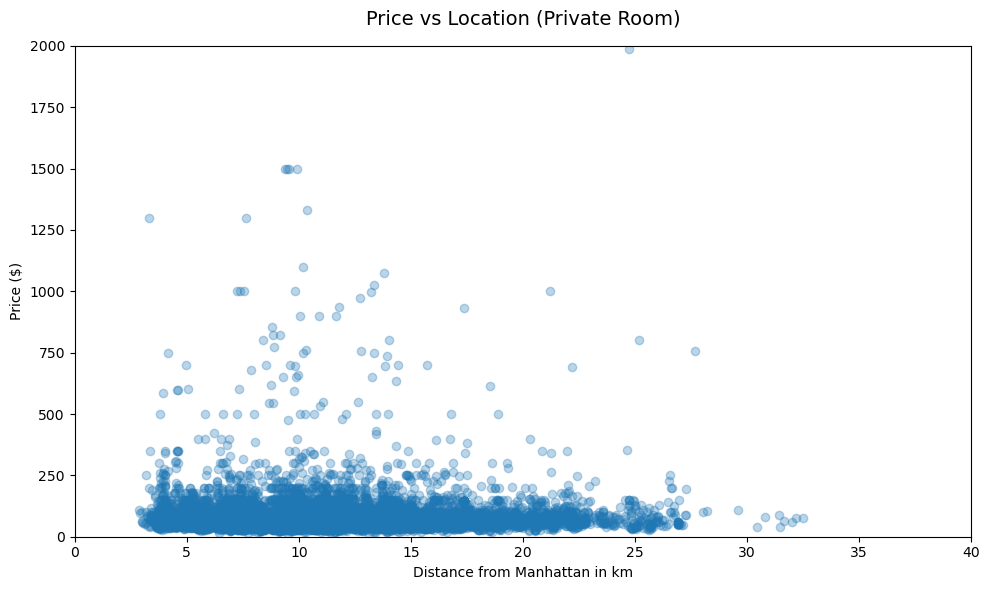

In [31]:
# Create scatter plot to visualize relationship between price and location
plt.figure(figsize=(10,6))
plt.scatter(private_room_x, private_room_y, alpha=0.3)
plt.title('Price vs Location (Private Room)', fontsize= 14, pad=15)
plt.xlabel('Distance from Manhattan in km')
plt.ylabel('Price ($)')
plt.xlim(0,40)
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

In [32]:
# Now I will do the same for Entire House/Apt Listings. I will copy and paste my code from above.
entire_home = listings_outside_manhattan[listings_outside_manhattan['room_type'] == 'Entire home/apt'].copy()
entire_home['coordinates'] = list(zip(entire_home['latitude'], entire_home['longitude']))
entire_home['distance_to_manhattan'] = entire_home['coordinates'].apply(haversine, args=[manhattan])
entire_home.sort_values(by=['distance_to_manhattan'], ascending=False)
entire_home.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,coordinates,distance_to_manhattan
4,5136,"Large Sunny Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1,"(40.66265, -73.99454)",12.829241
9,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,81,30,189,2023-02-04,1.13,1,207,5,"(40.70935, -73.95342)",7.636710
13,67299,Cozy Garden Apartment in Williamsburg,330347,Adrienne,Brooklyn,Williamsburg,40.71516,-73.96448,Entire home/apt,160,30,74,2022-06-26,0.51,1,77,1,"(40.71516, -73.96448)",6.864511
22,33009,Retreat in Williamsburg,143027,Ming,Brooklyn,Williamsburg,40.71512,-73.95899,Entire home/apt,195,30,291,2022-12-11,1.89,1,92,14,"(40.71512, -73.95899)",6.923103
26,7801,Sweet and Spacious Brooklyn Loft,21207,Chaya,Brooklyn,Williamsburg,40.71778,-73.95680,Entire home/apt,395,30,9,2011-12-28,0.05,1,365,0,"(40.71778, -73.9568)",6.662211


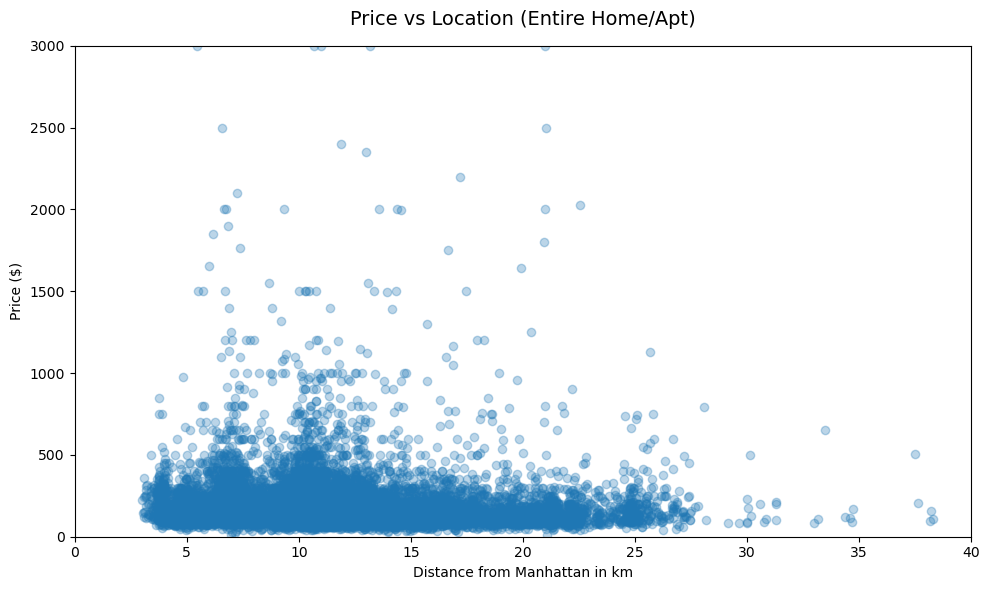

In [33]:
entire_home_x = entire_home['distance_to_manhattan'].values
entire_home_y = entire_home['price'].values
plt.figure(figsize=(10,6))
plt.scatter(entire_home_x, entire_home_y, alpha=0.3)
plt.title('Price vs Location (Entire Home/Apt)', fontsize= 14, pad=15)
plt.xlabel('Distance from Manhattan in km')
plt.ylabel('Price ($)')
plt.xlim(0, 40)
plt.ylim(0, 3000)
plt.tight_layout()
plt.show()

# Predicting Price Based on Location?

I wanted to know how accurately distance from Manhattan could predicate price, so I tried creating a predicative model based on those two variables. Unfortunatley my model did now behave as I expected and I soon realized that location alone, while it may have some predicative power, is not enough, and that many other factors influence Airbnb listing prices in New York City. 

When I evaluated my model using the R-squared (R²) score  and MAE (Mean Absolute Error) metrics, I found that it was a very poor predicator of price. This suggests that other factors such as room size, amentities, neighborhood quality, ratings, and property condition play a bigger role in determining price. I did not feel discouraged though, as this is a valuable finding in itself - it suggests that location (at least in terms of distance from Manhattan) isn't as important for determining price as I had initally thought. I have gained the valuable insight that a multitude of variables go into shaping price. 


In [34]:
private_room_x= private_room_x.reshape(-1, 1)


In [35]:
regression = LinearRegression()
regression.fit(private_room_x, private_room_y)

LinearRegression()

In [36]:
regression.coef_[0]

4.236838125985809

In [37]:
regression.intercept_

49.88561712583289

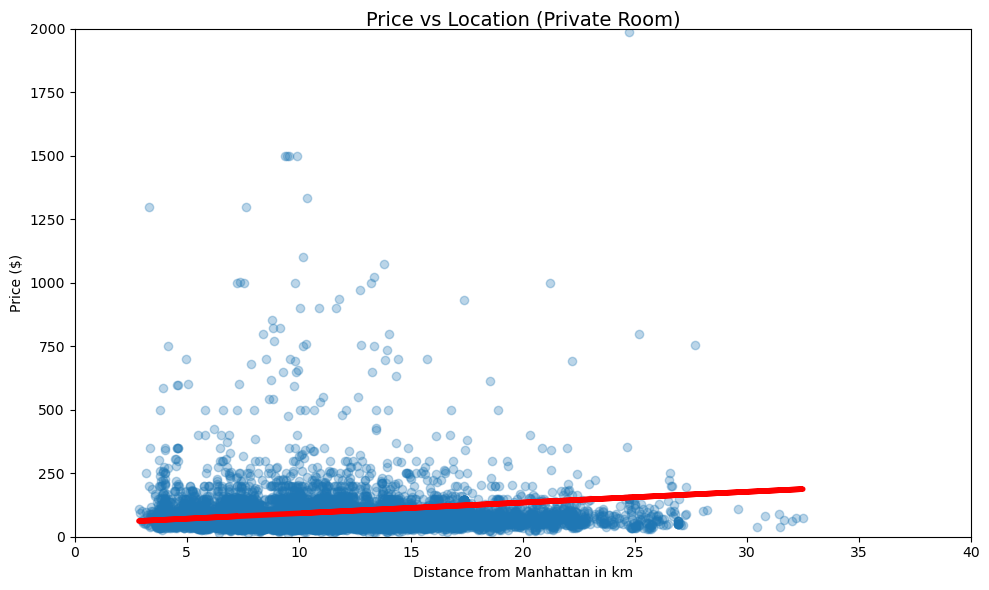

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(private_room_x, private_room_y, alpha=0.3)
plt.plot(private_room_x, regression.predict(private_room_x), color='red', linewidth=4)
plt.title('Price vs Location (Private Room)', fontsize= 14, pad=1)
plt.xlabel('Distance from Manhattan in km')
plt.ylabel('Price ($)')
plt.xlim(0,40)
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

In [39]:
entire_home_x = entire_home['distance_to_manhattan'].values.reshape(-1, 1)
regression = LinearRegression()
regression.fit(entire_home_x, entire_home_y)

LinearRegression()

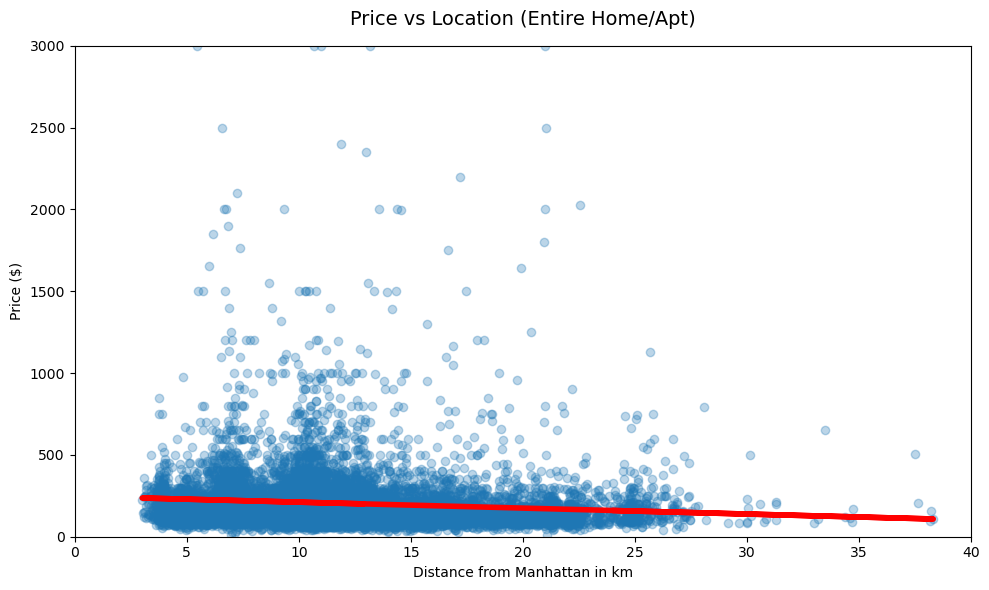

In [40]:
plt.figure(figsize=(10,6))
plt.scatter(entire_home_x, entire_home_y, alpha=0.3)
plt.plot(entire_home_x, regression.predict(entire_home_x), color='red', linewidth=4)
plt.title('Price vs Location (Entire Home/Apt)', fontsize= 14, pad=15)
plt.xlabel('Distance from Manhattan in km')
plt.ylabel('Price ($)')
plt.xlim(0, 40)
plt.ylim(0, 3000)
plt.tight_layout()
plt.show()

In [41]:
# Evaluate model
r2_score = regression.score(entire_home_x, entire_home_y,)
print(f"r2 score = {r2_score}") 
y_pred = regression.predict(entire_home_x)  
mae = mean_absolute_error(entire_home_y, y_pred) 
print(f"mae = {mae}")


r2 score = 0.0003707928613414513
mae = 106.36605685220682


# Conclusion and Future Projects 

In this analysis of Airbnb listings in New York City, I explored the relationship between location and pricing across different boroughs and neighborhoods. Through various visualizations, I was able to identify notable trends, such as significant price variations across boroughs, with Manhattan consistently showing the highest median prices. Neighborhood-level analysis further revealed that proximity to popular areas and landmarks heavily influences pricing. Scatter plots revealed that the correlation between higher prices and distance from Manhattan was not as strong as initially expected, highlighting that multiple factors contribute to pricing trends. Overall, these findings demonstrate that geographic location, neighborhood characteristics, and proximity to key attractions, among many other things, all play a role in determining Airbnb listing prices in NYC. 

In a future project, if I were to work on improving my statistical model, I would use multiple linear regression instead. This is because my findings have lead me to the conclusion that the influences that go into determining Airbnb prices are multifactorial. This method is commonly used for predicting real estate prices, and I believe it would work well in this context, where multiple variables such as property size, rating, location, and amenities all play a role in determining price. I was unable to build this model due to the limited features in the dataset, which was sourced from Kaggle.com. However, if additional data on property size, rating, and amenities were included, I would implement this model, as I believe it would provide more accurate predictions. 
